In [1]:
import pandas as pd
import itertools
from tqdm import tqdm
from scipy.optimize import minimize
import quantstats as qs
import numpy as np
from datetime import datetime
from sklearn.decomposition import PCA
import missingno as msno
from scipy.stats import johnsonsu
import matplotlib.pyplot as plt

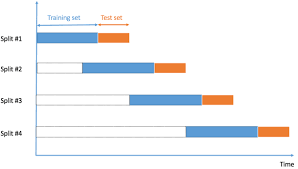

Para el backtesting se considera:
- El periodo de entrenamiento de 630 periodos, y el primero tenido en cuenta es el qué termina en el primer dato disponible del año 2010.
- A medida qué hay 630 datos disponibles de un etf, se lo agrega al portfolio.
- Un rebalanceo cada 63 periodos.
- Una reoptimización de los pesos cada 63 periodos.
- 100 muestras simuladas para cada optimización. El peso óptimo se considera como el promedio de los pesos óptimos para cada una de las simulaciones.
- Como longitud de las simulaciones se toma el periodo de rebalanceo.
- Un peso máximo permitido del 30%, para evitar concentración de activos.
- Para la composición del portfolio no se consideran posiciones en corto.


In [110]:
prices = pd.read_csv('prices_etf.csv',index_col='Unnamed: 0')
#prices = prices.dropna()
prices.index = pd.to_datetime(prices.index)
prices.index = [x.astimezone(None) for x in prices.index]


<AxesSubplot:>

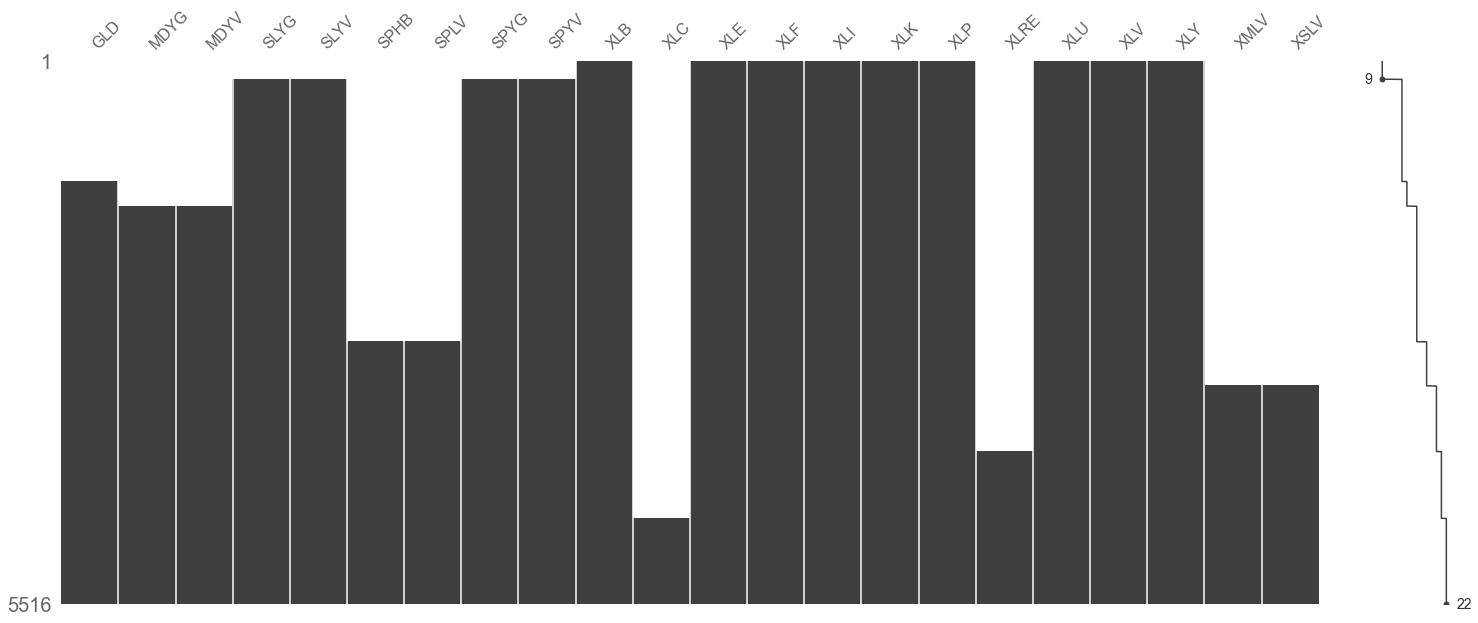

In [125]:
msno.matrix(prices)

# Un poco sobre simulaciones
- Retornos de mercado entre los distintos ETFs están correlacionadas.
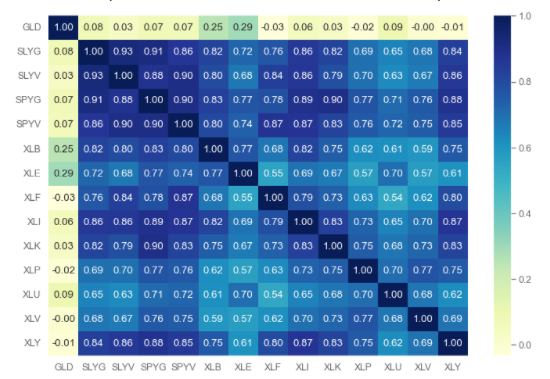
- Descomposición PCA : las series temporales se descomponen en series descorrelacionadas.
- Se ajusta cada componente con una función Jonhson’s SU.
- A las medias de las distribuciones se las toma como variables aleatorias y se realiza el mismo procedimiento anterior

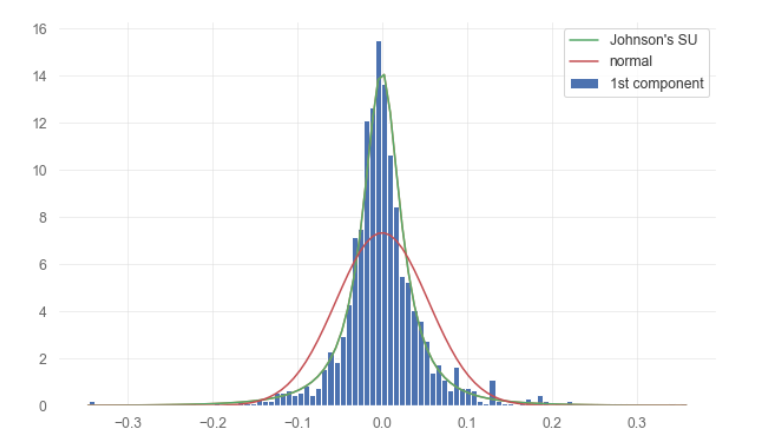

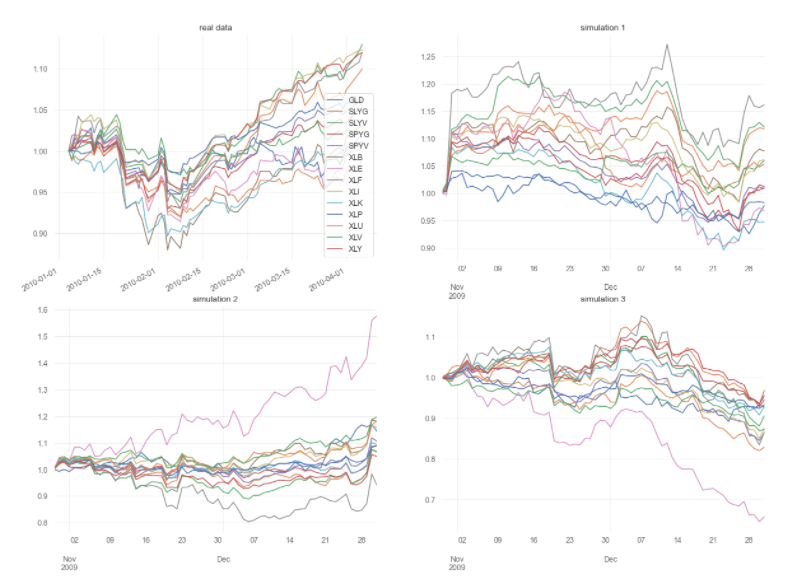

In [121]:
# -*- coding: utf-8 -*-
"""
BACKTEST
"""
# for 


class BackTest():
    def __init__(self,
                 function_to_optimize,
                 bounds=None,
                 test_periods = 63,
                 train_periods = 0,
                 period_number_to_train_again = 10,
                 simulation_variable_mean=True,
                 simulation_length=63,
                 n_simulations=200,
                 tolerance=1e-10

             ):
        """
        

        Parameters
        ----------
        function_to_optimize : function
            Funcion a optimzar.
        bounds : int, optional
            limites de cada peso posible. The default is None.
        test_periods : int, optional
            periodo de rebalanceo. The default is 63.
        train_periods : int, optional
            cuanto periodos toma para entrenar y generar las simulaciones, por defecto toma toda la data disponible. The default is 0.
        period_number_to_train_again : int, optional
            periodos de test antes de volver optimizar. The default is 10.
        simulation_variable_mean : bool, optional
            utilizar media variable para la simulacion. The default is True.
        simulation_length : int, optional
            longitud de la simulacion. The default is 1000.
        n_simulations : int, optional
            DESCRIPTION. The default is 100.
         : int
            numero de simulaciones generadas.

        Returns
        -------
        None.

        """
        
        if not bounds:
            self.bounds = [(0.0,0.3) for _ in range(len(prices.columns))]
        self.function_to_optimize = function_to_optimize
        self.test_periods = test_periods
        self.train_periods = train_periods
        self.period_number_to_train_again = period_number_to_train_again
        self.simulation_length = simulation_length
        self.n_simulations = n_simulations
        self.tolerance = tolerance
    

    def get_optimal_weights(self, prices):
        constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1.0},
                      {'type': 'ineq', 'fun': lambda x: x})
        initial_weights = np.ones(len(prices.columns))/len(prices.columns)

        optimize_result = minimize(fun=self.function_to_optimize,
                                x0=initial_weights,
                                args=(prices),
                                bounds=self.bounds[:len(initial_weights)],
                                method='SLSQP',
                                constraints=constraints,
                                tol=self.tolerance,
                                options={'disp': False})
        weights = optimize_result.x
        return weights


    def get_optimal_weights_mean(self, prices, test_periods):

        simulated_prices = self.simulate_markets(prices,self.n_simulations,self.simulation_length,self.test_periods)

        factor = 1/len(simulated_prices)
        weights_mean = np.zeros(len(prices.columns))

        for sim_prices in tqdm(simulated_prices):
          weights = self.get_optimal_weights(prices)
          weights_mean += weights * factor 
        print(self.function_to_optimize(weights_mean,prices))
        return weights_mean
    
    def simulate_means(self,returns,n_simulations=500,test_period=64):
        returns_means = returns.rolling(test_period).mean().dropna()
        pca = PCA()#inicializo pca
        pca_transform = pca.fit_transform(returns_means)#ajusto pca a los datos
        pca_transform = pd.DataFrame(pca_transform,index=returns_means.index)#lo transformo en un DataFrame
        functions_params = {}
        for cols in pca_transform.columns:
            params = johnsonsu.fit(pca_transform[cols],floc=0) #ajusto la funcion los componentes principales
            functions_params[cols] = params
            
        simulated_pca = pd.DataFrame()
        for cols in pca_transform.columns:
            simulated_pca[cols] = johnsonsu.rvs(*functions_params[cols],n_simulations)#simulo los datos para cada columna
        simulated_means = np.dot(simulated_pca,pca.components_)
        simulated_means = pd.DataFrame(simulated_means,columns=returns.columns)
        
        simulated_means = simulated_means + pca.mean_
        return simulated_means
    
    def simulate_markets(self,prices,n_simulations=500,simulation_length=1000,test_period=64):
        """
        Parameters
        ----------
        prices : pd.DataFrame
            DataFrame with stock prices.
        n_simulations : int, optional
            number of simulations that will be generated. The default is 50.
    
        Returns
        -------
        simulations : list
            list with DataFrame of simulated prices.
    
        """
        returns = np.log(1+prices.pct_change().dropna())
        simulated_means = self.simulate_means(returns,n_simulations,test_period)
        
        returns = returns - returns.mean() 
        pca = PCA()#inicializo pca
        pca_transform = pca.fit_transform(returns)#ajusto pca a los datos
        pca_transform = pd.DataFrame(pca_transform,index=returns.index)#lo transformo en un DataFrame
        functions_params = {}
        for cols in pca_transform.columns:
            params = johnsonsu.fit(pca_transform[cols],floc=0) #ajusto la funcion los componentes principales
            functions_params[cols] = params
            
        simulations = []
        
        for i in range(0,n_simulations):
            simulated_pca = pd.DataFrame()
            for cols in pca_transform.columns:
                simulated_pca[cols] = johnsonsu.rvs(*functions_params[cols],size=simulation_length)#simulo los datos para cada columna
            simulated_returns = np.dot(simulated_pca,pca.components_)
            date_range_index = pd.date_range(periods=simulation_length,end=returns.iloc[-1].name,freq='d')
            simulated_returns = pd.DataFrame(simulated_returns,index=date_range_index,columns=returns.columns)
            
            simulated_returns = simulated_returns + simulated_means.loc[i]
            
            simulated_normalized_prices = (np.exp(simulated_returns)).cumprod()
            simulated_prices = simulated_normalized_prices.multiply(prices.iloc[0])
            
            simulations.append(simulated_prices)
        return simulations


    def get_returns(self, weights, prices):
        portfolio_returns = (weights * (prices/prices.iloc[0])).sum(axis=1).pct_change().dropna()
        return portfolio_returns


    def run(self,prices,start_date,benchmark=False):
        returns = pd.Series()
        weights_list = []
        period_number = 0
        test_sample_length = len(prices.loc[start_date:]) 
        for i in range(0,test_sample_length,self.test_periods):
            
            start_test_period = prices.loc[start_date:].index[i]
            end_test_period = prices.loc[start_date:].index[min(i+self.test_periods,test_sample_length-1)]
            start_train_period = prices.loc[:start_test_period].index[-self.train_periods]
            prices_train = prices.loc[start_train_period:start_test_period]
            
            #train
            if not period_number % self.period_number_to_train_again:
                prices_train = prices_train.T.dropna().T
                tickers = prices_train.columns
                number_of_tickers = len(tickers)
                if benchmark:
                    weights = np.ones(number_of_tickers)/number_of_tickers
                else:
                    weights = self.get_optimal_weights_mean(prices_train,self.test_periods)
            #test
            prices_test = prices.loc[start_test_period:end_test_period,tickers]
            returns = returns.append(self.get_returns(weights,prices_test))
            weights_list.append({'start_date':start_test_period,'asset_number':number_of_tickers})
            for col, w in zip(tickers,weights):
                weights_list[-1].update({col:w})
            period_number +=1
                
        weights_df = pd.DataFrame(weights_list)
        weights_df = weights_df.set_index('start_date')
        weights_df = weights_df.replace(np.nan,0)
        return returns,weights_df



In [126]:
class Metrics():

    def _allocation_risk(self, weights, covariances):
        "Calcula el risego del portfolio. Devuelve un valor"
        portfolio_risk = np.sqrt((weights * covariances * weights.T))[0, 0]
        return portfolio_risk


    def _assets_risk_contribution_to_allocation_risk(self,weights, covariances):
        """Calcula el aporte de riesgo de cada activo del portafolio. Devuelve una
        matriz con valores entre 0 y 1. Ref.: https://quantpedia.com/risk-parity-asset-allocation/"""
        portfolio_risk = self._allocation_risk(weights, covariances)
        assets_risk_contribution = np.multiply(weights.T, covariances * weights.T) \
            / portfolio_risk
        return assets_risk_contribution


    def _risk_budget_objective_error(self,weights, prices):
        """Función a optimizar. 
            TARGET = portfolio_risk * assets_risk_budget = portfolio_risk * [1 / prices.shape[1]] * prices.shape[1]
            """
        
        covariances = 252 * prices.pct_change().iloc[1:, :].cov().values #no tengo claro si acá sea multimplica por 252
        assets_risk_budget = [1 / prices.shape[1]] * prices.shape[1]
        
        weights = np.matrix(weights)
        portfolio_risk = self._allocation_risk(weights, covariances)

        assets_risk_contribution = \
            self._assets_risk_contribution_to_allocation_risk(weights, covariances)

        assets_risk_target = \
            np.asmatrix(np.multiply(portfolio_risk, assets_risk_budget))

        error = \
            sum(np.square(assets_risk_contribution - assets_risk_target.T))[0, 0]
        return error*1e6
    
    def calculate_downside_volatility(self,returns, periods=252):
        mean = returns.mean()
        N = len(returns[returns<0])
        negative_variance = ((returns[returns<0]-mean)**2).sum()/(N-1)
        negative_volatility = np.sqrt(negative_variance)
        return negative_volatility*np.sqrt(periods) 

    def portfolio_return_series(self,weights,prices):
        portfolio = (weights*(prices/prices.iloc[0])).sum(axis=1)
        returns = portfolio.pct_change().dropna()
        return returns
    
    def get_expected_returns(self,returns,periods=252):
        return periods*(np.exp(np.log(1+returns).mean())-1)
        
    def sortino(self,weights,prices):
        portfolio_returns = self.portfolio_return_series(weights,prices)
        exp_return = self.get_expected_returns(portfolio_returns)
        neg_volatility = self.calculate_downside_volatility(portfolio_returns)
        return (-100)*exp_return/neg_volatility
    
    def calmar(self,weights,prices):
        portfolio_returns = self.portfolio_return_series(weights,prices)
        exp_return = self.get_expected_returns(portfolio_returns)
        maxDD = qs.stats.max_drawdown(portfolio_returns)
        return 100*exp_return/maxDD
        
    def return_over_cvar(self,weights,prices):
        portfolio_returns = self.portfolio_return_series(weights,prices)
        exp_return = self.get_expected_returns(portfolio_returns)
        cvar = qs.stats.cvar(portfolio_returns)
        return 100*exp_return/cvar
    
    def custom_function(self,weights,prices):   
        portfolio_returns = self.portfolio_return_series(weights,prices)
        metric = self.get_expected_returns(portfolio_returns)**3
        metric /= qs.stats.cvar(portfolio_returns)
        metric /= qs.stats.max_drawdown(portfolio_returns)
        metric /= self.calculate_negative_volatility(portfolio_returns)
        metric = (-1)*metric
        return metric*100
    

In [129]:
metrics = Metrics()
portfolio_returns = pd.DataFrame()
functions_list = {'Custom Function':metrics.custom_function,
                  'Return over CVaR':metrics.return_over_cvar,
                  'Sortino':metrics.sortino,
                  'Calmar':metrics.calmar,
                  'Risk Parity':metrics._risk_budget_objective_error,
                  }
weights = {}
for key,function in functions_list.items():
    bt = BackTest(function,
                n_simulations=100,
                train_periods = 630,
                period_number_to_train_again = 1,
                 )
    returns, weights_ = bt.run(prices,datetime(2010,1,1))
    portfolio_returns[key]=returns
    weights[key] = weights_

bt = BackTest(function,
                n_simulations=10,
                  train_periods = 630,
                  )
returns, weights_ = bt.run(prices,datetime(2010,1,1),benchmark=True)
portfolio_returns['Benchmark']=returns
weights['Benchmark'] = weights_


C:\Users\Fran\AppData\Local\Temp/ipykernel_57384/3828921884.py:163: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  returns = pd.Series()
100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:46<00:00,  2.13it/s]


-30.94316734596085


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:36<00:00,  2.73it/s]


-16.878951988246406


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:21<00:00,  4.62it/s]


-1.8978319169772464


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [05:49<00:00,  3.49s/it]


-14.67407294151408


100%|████████████████████████████████████████████████████████████████████████████| 100/100 [11:47:07<00:00, 424.28s/it]


-98.62771825159659


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:25<00:00,  3.90it/s]


-409.0579716882661


  0%|                                                                                          | 0/100 [00:00<?, ?it/s]C:\Users\Fran\Anaconda3\lib\site-packages\scipy\optimize\optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:25<00:00,  3.86it/s]


-2722.1951302175926


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [01:51<00:00,  1.11s/it]


-4370.944825982183


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [02:06<00:00,  1.27s/it]


-4626.847277781526


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [03:46<00:00,  2.26s/it]


-3074.7742439123517


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [04:15<00:00,  2.56s/it]


-1936.686161014557


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:12<00:00,  7.73it/s]


-2315.7986691449764


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [02:12<00:00,  1.33s/it]


-2912.493539977206


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [05:30<00:00,  3.30s/it]


-2697.6942743717814


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [03:15<00:00,  1.95s/it]


-1316.5704662211251


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [02:27<00:00,  1.47s/it]


-1207.9006403886497


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [04:11<00:00,  2.51s/it]


-1241.6190700627758


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [02:21<00:00,  1.42s/it]


-8757.94253761064


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [05:41<00:00,  3.42s/it]


-8746.39247832102


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [08:48<00:00,  5.28s/it]


-5513.005194024526


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [03:17<00:00,  1.97s/it]


-7480.102340469867


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [01:46<00:00,  1.06s/it]


-6997.147111966562


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [03:42<00:00,  2.23s/it]


-6648.832971687377


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [05:21<00:00,  3.22s/it]


-1087.877442426732


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [05:01<00:00,  3.02s/it]


-1009.9140672445654


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [02:25<00:00,  1.46s/it]


-1655.5289759389293


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [02:31<00:00,  1.52s/it]


-1696.453504257152


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [10:58<00:00,  6.59s/it]


-736.5977095185908


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [09:52<00:00,  5.93s/it]


-968.795533190489


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [04:42<00:00,  2.83s/it]


-1859.5263709602932


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [07:09<00:00,  4.29s/it]


-1041.10614049623


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [06:53<00:00,  4.14s/it]


-1777.6869287323948


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [05:29<00:00,  3.30s/it]


-3179.5764188135904


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [06:51<00:00,  4.11s/it]


-2440.3537308588357


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [02:34<00:00,  1.54s/it]


-5061.284304495336


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [08:49<00:00,  5.29s/it]


-2885.9545101781114


  0%|                                                                                          | 0/100 [00:00<?, ?it/s]C:\Users\Fran\Anaconda3\lib\site-packages\scipy\optimize\optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [05:40<00:00,  3.40s/it]


-266.59507087632215


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [04:09<00:00,  2.49s/it]


-1370.5976086100284


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [01:57<00:00,  1.17s/it]


-2992.631626770936


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:17<00:00,  5.87it/s]


-2203.732977128977


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [02:16<00:00,  1.36s/it]


-3235.2420895795044


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [05:58<00:00,  3.58s/it]


-94.89694294527816


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [01:01<00:00,  1.62it/s]


-219.45651558744038


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [04:01<00:00,  2.42s/it]


-357.484614473631


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [03:31<00:00,  2.12s/it]


-492.483497747845


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [05:43<00:00,  3.43s/it]


-593.7273210510517


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:17<00:00,  5.74it/s]


-997.3174019140044


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:17<00:00,  5.59it/s]
C:\Users\Fran\AppData\Local\Temp/ipykernel_57384/3828921884.py:163: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  returns = pd.Series()


-594.5082114672283


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:19<00:00,  5.14it/s]


-286.9856741032861


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [01:49<00:00,  1.10s/it]


-227.98330798165966


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:15<00:00,  6.42it/s]


-111.04287572425541


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:15<00:00,  6.36it/s]


-216.00440425602858


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [01:53<00:00,  1.14s/it]


-416.77444038052454


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:55<00:00,  1.81it/s]


-663.721629526376


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [02:42<00:00,  1.62s/it]


-1147.568842176834


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [03:36<00:00,  2.17s/it]


-1173.5098561874343


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [07:16<00:00,  4.37s/it]


-1202.1028961215557


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:42<00:00,  2.38it/s]


-1072.4231968310842


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [03:24<00:00,  2.05s/it]


-875.4951346438306


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 12.80it/s]


-924.1297274294459


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [04:15<00:00,  2.55s/it]


-1039.560306149082


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [05:35<00:00,  3.35s/it]


-999.1923342846453


  0%|                                                                                          | 0/100 [00:00<?, ?it/s]C:\Users\Fran\Anaconda3\lib\site-packages\scipy\optimize\optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [02:06<00:00,  1.27s/it]


-852.7903053319923


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [03:01<00:00,  1.82s/it]


-816.937088549491


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:13<00:00,  7.41it/s]


-837.9539647870724


  0%|                                                                                          | 0/100 [00:00<?, ?it/s]C:\Users\Fran\Anaconda3\lib\site-packages\scipy\optimize\optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [02:32<00:00,  1.53s/it]


-1467.4068532283763


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [03:30<00:00,  2.11s/it]


-1485.9477974874435


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [04:34<00:00,  2.74s/it]


-1223.7861677618207


  0%|                                                                                          | 0/100 [00:00<?, ?it/s]C:\Users\Fran\Anaconda3\lib\site-packages\scipy\optimize\optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [03:11<00:00,  1.91s/it]


-1349.542750333306


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [05:43<00:00,  3.43s/it]


-1363.4531990871894


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:13<00:00,  7.59it/s]


-1249.2081934611826


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [06:19<00:00,  3.79s/it]


-787.0896792350065


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [01:19<00:00,  1.26it/s]


-780.2331451433378


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [04:02<00:00,  2.43s/it]


-935.0428833662655


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [06:22<00:00,  3.83s/it]


-934.7146021255444


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [01:50<00:00,  1.10s/it]


-713.5192291083322


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [03:14<00:00,  1.94s/it]


-769.3548898603487


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [02:18<00:00,  1.38s/it]


-976.6229120610698


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [03:19<00:00,  2.00s/it]


-809.2156553207752


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [02:32<00:00,  1.52s/it]


-965.7199304929545


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [02:05<00:00,  1.25s/it]


-1179.4053915470254


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [08:53<00:00,  5.34s/it]


-1048.2864676403392


  0%|                                                                                          | 0/100 [00:00<?, ?it/s]C:\Users\Fran\Anaconda3\lib\site-packages\scipy\optimize\optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [03:03<00:00,  1.84s/it]


-1376.287108257077


  0%|                                                                                          | 0/100 [00:00<?, ?it/s]C:\Users\Fran\Anaconda3\lib\site-packages\scipy\optimize\optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [05:53<00:00,  3.53s/it]


-1074.2745443117149


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [06:21<00:00,  3.81s/it]


-556.3268285929765


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [03:53<00:00,  2.34s/it]


-916.9914328032505


  0%|                                                                                          | 0/100 [00:00<?, ?it/s]C:\Users\Fran\Anaconda3\lib\site-packages\scipy\optimize\optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [04:54<00:00,  2.95s/it]


-1200.9077458519687


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [03:06<00:00,  1.86s/it]


-1042.6340863567061


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [03:13<00:00,  1.93s/it]


-1209.5704471635308


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [02:43<00:00,  1.63s/it]


-374.7731489276086


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [01:47<00:00,  1.08s/it]


-497.2161303159165


  0%|                                                                                          | 0/100 [00:00<?, ?it/s]C:\Users\Fran\Anaconda3\lib\site-packages\scipy\optimize\optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [02:04<00:00,  1.25s/it]


-593.9041425810481


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [01:18<00:00,  1.27it/s]


-627.8201990980172


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [04:28<00:00,  2.69s/it]


-674.1588529972868


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [03:21<00:00,  2.02s/it]


-819.3378017763375


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [01:28<00:00,  1.13it/s]
C:\Users\Fran\AppData\Local\Temp/ipykernel_57384/3828921884.py:163: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  returns = pd.Series()


-700.4998595994094


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:14<00:00,  7.09it/s]


-39.67704391112998


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:12<00:00,  7.91it/s]


-32.971264965128846


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:15<00:00,  6.32it/s]


-16.46235609943372


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [02:27<00:00,  1.48s/it]


-31.698683721382118


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [01:21<00:00,  1.22it/s]


-57.00445817024042


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:28<00:00,  3.51it/s]


-82.66958330308319


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [01:34<00:00,  1.06it/s]


-137.68080668451057


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [02:15<00:00,  1.35s/it]


-141.73925643556217


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [01:59<00:00,  1.20s/it]


-141.820638854691


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [03:30<00:00,  2.11s/it]


-125.32324161637975


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:12<00:00,  7.94it/s]


-109.9579998068634


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [01:28<00:00,  1.13it/s]


-121.3653473084611


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [01:47<00:00,  1.07s/it]


-130.03531238298382


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:38<00:00,  2.58it/s]


-128.82084973177444


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [03:17<00:00,  1.98s/it]


-109.20987299989577


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [03:14<00:00,  1.95s/it]


-107.30724715139031


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [01:31<00:00,  1.09it/s]


-111.36172463354909


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [02:12<00:00,  1.33s/it]


-184.40869920101477


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [07:29<00:00,  4.49s/it]


-180.83278916339825


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [01:36<00:00,  1.04it/s]


-158.23195191011382


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [02:36<00:00,  1.56s/it]


-170.0125533495636


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [02:59<00:00,  1.79s/it]


-163.52223649982227


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [02:02<00:00,  1.22s/it]


-156.37926697135242


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [04:46<00:00,  2.87s/it]


-100.50727864567287


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [02:08<00:00,  1.28s/it]


-101.23515803574666


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [03:42<00:00,  2.22s/it]


-114.89081713508808


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [02:42<00:00,  1.63s/it]


-118.38965818599581


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [01:22<00:00,  1.21it/s]


-87.93094236566361


  0%|                                                                                          | 0/100 [00:00<?, ?it/s]C:\Users\Fran\Anaconda3\lib\site-packages\scipy\optimize\optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [07:11<00:00,  4.31s/it]


-94.42508566950805


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [02:55<00:00,  1.76s/it]


-113.39532177203455


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [01:07<00:00,  1.49it/s]


-98.14116422841813


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [07:34<00:00,  4.55s/it]


-117.63214078527598


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [05:39<00:00,  3.40s/it]


-147.44866374671952


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [03:49<00:00,  2.29s/it]


-134.34232523180845


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [02:48<00:00,  1.69s/it]


-165.3153527853728


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [04:41<00:00,  2.82s/it]


-147.7300500104223


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [01:46<00:00,  1.06s/it]


-82.11300215097432


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [07:27<00:00,  4.48s/it]


-121.87159733617642


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [02:25<00:00,  1.46s/it]


-149.228869358481


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [01:47<00:00,  1.08s/it]


-131.03165327142335


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [02:11<00:00,  1.32s/it]


-148.4339572060477


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [04:41<00:00,  2.82s/it]


-58.16002655927071


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:24<00:00,  4.04it/s]


-69.9220619869654


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [02:23<00:00,  1.43s/it]


-87.44383794193028


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [04:13<00:00,  2.53s/it]


-94.79476901799916


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [08:01<00:00,  4.81s/it]


-97.70697373323422


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [02:24<00:00,  1.45s/it]


-115.90872652209147


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [03:11<00:00,  1.91s/it]
C:\Users\Fran\AppData\Local\Temp/ipykernel_57384/3828921884.py:163: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  returns = pd.Series()


-97.51016417974266


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:23<00:00,  4.26it/s]


-27.174729693576765


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:15<00:00,  6.38it/s]


-22.559790671205498


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:21<00:00,  4.57it/s]


-10.3818554673625


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:36<00:00,  2.76it/s]


-21.84590025012478


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:31<00:00,  3.20it/s]


-41.90575864244344


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:48<00:00,  2.04it/s]


-79.25352979133346


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [01:30<00:00,  1.11it/s]


-185.2478980958394


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [03:16<00:00,  1.97s/it]


-272.3832984512742


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [06:53<00:00,  4.14s/it]


-274.96266853197454


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [04:39<00:00,  2.79s/it]


-239.3476048951641


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [02:21<00:00,  1.41s/it]


-204.8346884571468


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [02:01<00:00,  1.21s/it]


-215.14681907917893


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [02:55<00:00,  1.76s/it]


-226.06572919529472


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [03:37<00:00,  2.18s/it]


-217.23851845151367


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [03:23<00:00,  2.04s/it]


-171.42543223133507


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [03:55<00:00,  2.35s/it]


-164.23324245035198


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [05:26<00:00,  3.26s/it]


-158.7849169317913


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:32<00:00,  3.11it/s]


-355.3263892029932


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [01:37<00:00,  1.03it/s]


-348.04131533950033


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [04:01<00:00,  2.42s/it]


-305.2648282939898


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [05:04<00:00,  3.04s/it]


-338.72384834987497


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [06:38<00:00,  3.99s/it]


-339.74508367923596


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [06:04<00:00,  3.64s/it]


-367.2157053774673


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [03:22<00:00,  2.02s/it]


-139.57506852780327


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [05:59<00:00,  3.60s/it]


-129.19556281077587


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [02:17<00:00,  1.38s/it]


-156.2458883293073


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [05:13<00:00,  3.14s/it]


-160.27067481877492


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:21<00:00,  4.64it/s]


-119.86335173010544


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [07:34<00:00,  4.54s/it]


-139.1228805040594


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [03:56<00:00,  2.37s/it]


-173.3442183636753


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [05:02<00:00,  3.03s/it]


-136.3963732495449


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [04:53<00:00,  2.94s/it]


-168.375419142647


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [05:00<00:00,  3.01s/it]


-205.61901165668783


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [03:29<00:00,  2.10s/it]


-177.9936787422698


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [03:41<00:00,  2.22s/it]


-244.83492038336558


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:25<00:00,  3.89it/s]


-210.40523443871106


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [03:01<00:00,  1.82s/it]


-63.67802551448882


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [01:17<00:00,  1.29it/s]


-136.42274793923073


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [03:05<00:00,  1.85s/it]


-176.9666406157045


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [02:00<00:00,  1.20s/it]


-165.99104540621806


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:59<00:00,  1.68it/s]


-183.46789255694256


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:25<00:00,  3.95it/s]


-46.90933333068908


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:37<00:00,  2.65it/s]


-64.03844114521087


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:42<00:00,  2.36it/s]


-76.80654142466442


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [03:04<00:00,  1.85s/it]


-85.81831225197153


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:59<00:00,  1.68it/s]


-90.78702263161237


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:37<00:00,  2.64it/s]


-108.9422282307918


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:16<00:00,  5.92it/s]
C:\Users\Fran\AppData\Local\Temp/ipykernel_57384/3828921884.py:163: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  returns = pd.Series()


-91.60431309210333


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [01:03<00:00,  1.57it/s]


2.5072302541600734e-11


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [01:07<00:00,  1.48it/s]


2.5020829856411277e-11


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [01:08<00:00,  1.47it/s]


2.694030272397387e-11


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [01:06<00:00,  1.50it/s]


3.228719015590913e-11


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [01:06<00:00,  1.51it/s]


3.5277933708039e-11


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [01:10<00:00,  1.42it/s]


7.496038757982024e-11


  0%|                                                                                          | 0/100 [00:00<?, ?it/s]C:\Users\Fran\Anaconda3\lib\site-packages\scipy\optimize\optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [01:02<00:00,  1.60it/s]


2.357203614245561e-11


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [01:05<00:00,  1.54it/s]


1.35025732866364e-11


  0%|                                                                                          | 0/100 [00:00<?, ?it/s]C:\Users\Fran\Anaconda3\lib\site-packages\scipy\optimize\optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:55<00:00,  1.80it/s]


1.4705250442895905e-11


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:54<00:00,  1.83it/s]


9.349881682746324e-12


  0%|                                                                                          | 0/100 [00:00<?, ?it/s]C:\Users\Fran\Anaconda3\lib\site-packages\scipy\optimize\optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:59<00:00,  1.68it/s]


8.499922820729802e-12


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [01:03<00:00,  1.57it/s]


1.889932219810598e-11


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:58<00:00,  1.71it/s]


2.3167374073660717e-11


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:56<00:00,  1.78it/s]


8.617688224879926e-12


  0%|                                                                                          | 0/100 [00:00<?, ?it/s]C:\Users\Fran\Anaconda3\lib\site-packages\scipy\optimize\optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [01:01<00:00,  1.63it/s]


9.213928815741379e-12


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:53<00:00,  1.86it/s]


6.3143631747053124e-12


  0%|                                                                                          | 0/100 [00:00<?, ?it/s]C:\Users\Fran\Anaconda3\lib\site-packages\scipy\optimize\optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [01:32<00:00,  1.09it/s]


8.118379070973953e-12


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [01:24<00:00,  1.18it/s]


6.781515834065906e-12


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [01:27<00:00,  1.14it/s]


2.5617463247799046e-11


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [01:23<00:00,  1.19it/s]


5.3108071496436286e-11


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [01:29<00:00,  1.12it/s]


8.591794983927071e-12


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [01:37<00:00,  1.03it/s]


1.5125221141150094e-11


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [01:38<00:00,  1.02it/s]


3.051862178911767e-11


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [01:59<00:00,  1.19s/it]


2.8190182449376664e-12


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [01:54<00:00,  1.14s/it]


4.249751150652709e-12


  0%|                                                                                          | 0/100 [00:00<?, ?it/s]C:\Users\Fran\Anaconda3\lib\site-packages\scipy\optimize\optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [02:03<00:00,  1.23s/it]


2.6423759304284842e-12


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [03:15<00:00,  1.95s/it]


45.81565760617599


  0%|                                                                                          | 0/100 [00:00<?, ?it/s]C:\Users\Fran\Anaconda3\lib\site-packages\scipy\optimize\optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [03:39<00:00,  2.20s/it]


45.18597148515832


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [02:54<00:00,  1.75s/it]


45.536656160261906


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [02:05<00:00,  1.25s/it]


1.9802704871578674e-12


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [01:47<00:00,  1.07s/it]


41.47194085554049


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [03:38<00:00,  2.19s/it]


38.05100634237174


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [03:02<00:00,  1.82s/it]


35.924727384118235


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [03:11<00:00,  1.91s/it]


34.10674301966867


  0%|                                                                                          | 0/100 [00:00<?, ?it/s]C:\Users\Fran\Anaconda3\lib\site-packages\scipy\optimize\optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [03:24<00:00,  2.05s/it]


26.99964515532384


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [02:20<00:00,  1.40s/it]


4.191384014801398e-12


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [02:23<00:00,  1.43s/it]


2.759315385294054e-11


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [02:12<00:00,  1.32s/it]


3.135080415330562e-11


  0%|                                                                                          | 0/100 [00:00<?, ?it/s]C:\Users\Fran\Anaconda3\lib\site-packages\scipy\optimize\optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [02:19<00:00,  1.40s/it]


1.4087461299059423e-11


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [03:22<00:00,  2.02s/it]


31.171854151711937


  0%|                                                                                          | 0/100 [00:00<?, ?it/s]C:\Users\Fran\Anaconda3\lib\site-packages\scipy\optimize\optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [03:18<00:00,  1.99s/it]


30.733993076342337


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [02:19<00:00,  1.40s/it]


4.136526119333898e-11


  0%|                                                                                          | 0/100 [00:00<?, ?it/s]C:\Users\Fran\Anaconda3\lib\site-packages\scipy\optimize\optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [02:31<00:00,  1.51s/it]


2.9104694447603214e-11


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [02:32<00:00,  1.53s/it]


9.797783092966567e-11


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [02:42<00:00,  1.63s/it]


5.2239365526523576e-11


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [02:41<00:00,  1.61s/it]


3.735524850807574e-11


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [02:40<00:00,  1.60s/it]


3.6922581769703196e-11


  0%|                                                                                          | 0/100 [00:00<?, ?it/s]C:\Users\Fran\Anaconda3\lib\site-packages\scipy\optimize\optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [02:31<00:00,  1.51s/it]

4.853671736109537e-11



C:\Users\Fran\AppData\Local\Temp/ipykernel_57384/3828921884.py:163: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  returns = pd.Series()


In [4]:
(1+portfolio_returns).cumprod().plot()

NameError: name 'portfolio_returns' is not defined

In [131]:
for key in weights.keys():
    weights[key].to_csv('output/'+key+'_weights_v2.csv')
portfolio_returns.to_csv('output/portfolio_returns_v2.csv')
    

<AxesSubplot:>

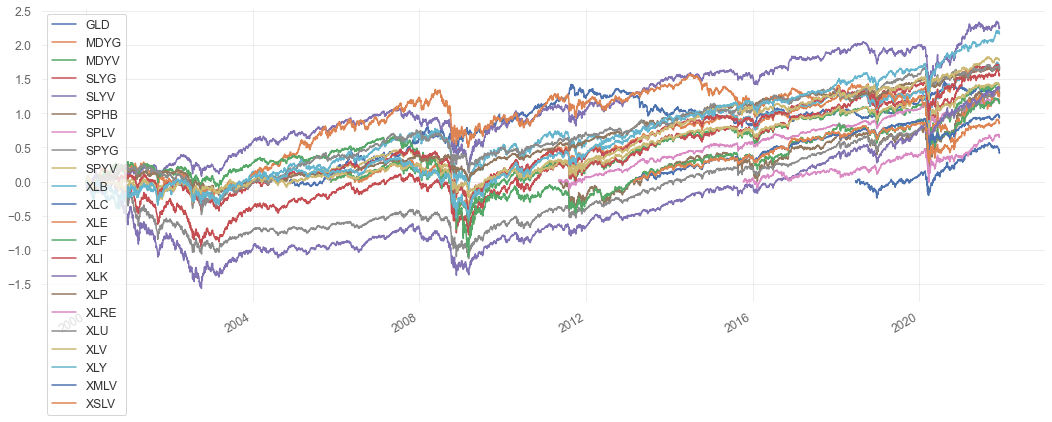

In [133]:
np.log(1+prices.pct_change()).cumsum().plot(figsize=(18,6))